<a href="https://colab.research.google.com/github/Sarnapa/Credit-Card-Fraud-Detection/blob/main/Notebooks/CreditCardFraudDetection_AnomalyDetectionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temat zadania: Analityczny - detekcja anomalii



Autorzy: Michał Bartnicki, Michał Piotrak

Kod zadania: DAz11

# Przygotowanie oraz konfiguracja środowiska uruchomieniowego

W tej sekcji umieszczamy listę zmiennych konfiguracyjnych, które mają wpływ na wykonanie przetwarzania zawartego w danym notatniku. Poza tym, przygotowaliśmy fragment skryptu, który zadba o instalacje niezbędnych bibliotek zewnętrznych.

In [18]:
# Lista zmiennych konfiguracyjnych

# Flaga, której ustawienie umożliwia szybsze wykonanie przetwarzania zawartego w notatniku
# w celu demonstracyjnym. Wiąże się z wczytaniem mniejszej ilości danych ze zbioru źródłowego.
QUICK_MODE = True
# Procent danych, który bierzemy pod uwagę przy pracy w trybie QUICK_MODE
QUICK_MODE_DATA_PERCENTAGE = 0.05
# Liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji
CV_FOLDS_COUNT = 5
if QUICK_MODE:
  CV_FOLDS_COUNT = 2

# Zainstalowanie niezbędnych bibliotek
try:
  import gdown
except ImportError:
  !pip install -q gdown

try:
  import imblearn
except ImportError:
  !pip install -q imbalanced-learn

try:
  import matplotlib.pyplot
except ImportError:
  !pip install -q matplotlib

try:
  import numpy as np
except ImportError:
  !pip install -q numpy

try:
  import pandas as pd
except ImportError:
  !pip install -q pandas

try:
  import sklearn
except ImportError:
  !pip install -q scikit-learn

# Wstępne przetwarzanie danych


## Charakterystyka danych

W naszym projekcie wykorzystujemy zbiór [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Poniżej przedstawiamy podgląd zbioru *creditcardfraud*

Ze względu na to, że metody nienadzorowane zwracają przy predykcji wartość -1 dla osobnika uznanego za reprezentanta klasy mniejszościowej, a dla klasy większościowej wartość większą niż 0, dokonujemy tutaj odpowiedniego mapowania etykiet, uznając, że etykieta "-1" określa przykłady uznane za oszustwa, za to etykieta "1" - jako transakcje regularne.

In [19]:
from enum import Enum

class Transaction(Enum):
    VALID_TRANSACTION = (1, "Transakcja regularna")
    FRAUD = (-1, "Oszustwo")

    def __init__(self, value, label):
        self._value_ = value
        self.label = label

    @classmethod
    def map_label(cls, df):
        """
        Mapuje wartości z oryginalnej kolumny "Class" (0 - transakcja regularna, 1 - oszustwo) na wartości zdefiniowane w Enum.
        """
        return df.map({0: cls.VALID_TRANSACTION.value, 1: cls.FRAUD.value})

    @classmethod
    def to_string(cls, val):
        """
        Zwraca postać tekstową etykiety.
        """
        for member in cls:
            if member.value == val:
                return member.label
        return str(val)

# Tworzymy mapę: {1: "Transakcja regularna", -1: "Oszustwo"}, która ułatwi nam interpretację danych / wyników
class_labels_map = {t.value: t.label for t in Transaction}

In [20]:
import os

# ID pliku z Google Drive
file_id = "14HSXm9CDBA0DxLfSxGCgXQxUXyBxvfno"
output_path = "creditcard.csv"

# Pobierz tylko, jeśli pliku jeszcze nie ma
if not os.path.exists(output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)
else:
    print("Plik ze zbiorem danych już istnieje lokalnie.")

# Wczytaj do DataFrame
df = pd.read_csv(output_path)

# Mapowanie etykiet
df["Class"] = Transaction.map_label(df["Class"])

print(df.head(3))


Plik ze zbiorem danych już istnieje lokalnie.
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      1  
1  0.125895 -0.008983  0.014724    2.69      1  
2 -0.139097 -0.055353 -0.059752  378.66      1  

[3 rows x 31 columns]


Poniżej przedstawiamy krótką charakterystykę danych.
Warto zauważyć, że zbiór jest wysoce niezbalansowany.

In [21]:
print("Liczba atrybutów:", df.shape[1] - 1)
print("Całkowita liczba transakcji:", df.shape[0], end='\n\n')
print("Odsetek oszustw i transakcji regularnych w całym zbiorze:\n\n",
      df['Class'].value_counts(normalize=True).rename(index=class_labels_map), end='\n\n')
print("Całkowita liczba oszustw i transakcji regularnych\n\n", df['Class'].value_counts().rename(index=class_labels_map))


Liczba atrybutów: 30
Całkowita liczba transakcji: 284807

Odsetek oszustw i transakcji regularnych w całym zbiorze:

 Class
Transakcja regularna    0.998273
Oszustwo                0.001727
Name: proportion, dtype: float64

Całkowita liczba oszustw i transakcji regularnych

 Class
Transakcja regularna    284315
Oszustwo                   492
Name: count, dtype: int64


In [22]:
# Do losowania wskazanego procentu danych, z zachowaniem proporcji klas
def stratified_sample(df, frac=0.2, seed=42):
    sampled_parts = []
    for label in df["Class"].unique():
        part = df[df["Class"] == label].sample(frac=frac, random_state=seed)
        sampled_parts.append(part)
    return pd.concat(sampled_parts).sample(frac=1, random_state=seed).reset_index(drop=True)

# Mniejszy zbiór danych do szybszego testowania z zachowaniem proporcji klas
if QUICK_MODE:
  df = stratified_sample(df, frac=QUICK_MODE_DATA_PERCENTAGE)

## Usuwanie duplikatów

Zbiór posiada następującą ilość duplikatów:



In [23]:
duplicates = df.duplicated(keep='first')
duplicates_count = duplicates.sum()
print(duplicates_count)

2


Należy usunąć je ze zbioru danych

In [24]:
df.drop_duplicates(inplace=True)
print("Usunięto duplikaty. Pozostało transakcji w zbiorze:", df.shape[0])


Usunięto duplikaty. Pozostało transakcji w zbiorze: 14239


## Sprawdzanie brakujących danych (NaN/null)
Dane nie posiadają transakcji z brakującymi atrybutami, nie ma konieczności usuwania

In [25]:
missing_data = df.isnull().values.any()
print(f"Zbiór nie zawiera brakujących danych (missing_data: {missing_data})")


Zbiór nie zawiera brakujących danych (missing_data: False)


## Skalowanie

Wiekszość atrybutów została już wczęsniej przeskalowana. Pozostało wykonać to samo dla kolumn:
- `Time`
- `Amount`

W tym celu wykorzystamy [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) z biblioteki scikit-learn, który jest odporny na wartości odstające.

In [26]:
from sklearn.preprocessing import RobustScaler

if set(['Amount','Time']).issubset(df.columns):
  scaler = RobustScaler()
  amount_scaled = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
  time_scaled = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
  df.drop(['Time', 'Amount'], axis=1, inplace=True)

  df.insert(0, 'time_scaled', time_scaled)
  df.insert(1, 'amount_scaled', amount_scaled)

print("Kolumny Amount i Time zostały przekształcone")
print(df.head(3))

Kolumny Amount i Time zostały przekształcone
   time_scaled  amount_scaled        V1        V2        V3        V4  \
0    -0.326365      -0.291096  1.181213  1.224356 -1.488377  1.679347   
1     0.977544      -0.294521  2.055618  0.682946 -3.150166  0.597500   
2     0.150763      -0.120006 -0.557542  1.064676  0.524862 -1.771705   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0  0.817619 -1.560638  0.670368 -0.239600  ... -0.112195 -0.167333 -0.373286   
1  1.367691 -1.249724  0.746882 -0.347442  ... -0.087419 -0.003718  0.193651   
2  1.141241 -0.310842  0.624603  0.006453  ... -0.081430 -0.514084 -1.286546   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.132332  0.061062  0.723608 -0.283007  0.053479  0.095746      1  
1 -0.050739  0.550247  0.370735  0.662582 -0.078566 -0.022028      1  
2 -0.119764 -0.201779 -0.333499  0.691922 -0.011959  0.155459      1  

[3 rows x 31 columns]


## Redukcja wymiarowości
Według opisu zbioru danych, dane przeszły tansformację PCA, która jest techniką
redukcji wymiarowości, co wskazuje na brak konieczności dalszych redukcji.
Sprawdzenie korelacji wszystkich par kolumn potwierdza nasze przypuszczenia.

In [27]:
correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highest_correlation = upper_triangle.max().max()

print(f"Najwyższa korelacja między dwoma dowolnymi parami atrybutów: {highest_correlation}")

Najwyższa korelacja między dwoma dowolnymi parami atrybutów: 0.49714708460719315


# Przygotowanie zbiorów treningowych oraz testowych



https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

1. Nie testować na danych, które zostały under lub oversamplowane.

2. Tutaj radzą, że jak używamy k krotną walidację to podczas jej robić to under / oversamplowanie

Plan:
1. Wpleść w k krotną walidację alternatywe ze mozna uzyc undersampling i oversampling - zrobione
2. Dla undersamplingu i oversamplingu pokazac liczbe przykladow tych dwoch klas i porownanie z tym jak bylo wczesniej - zrobione

Jeszcze do pomyślenia:
1. Bo generalnie w praktyce to chyba jest tak, że na początek dzielimy sobie dany zbiór na treningowy i testowy i następnie ten treningowy podajemy działaniu krzyżowej walidacji, gdzie mamy podział na zbiór treningowy i walidacyjny i w wyniku tego możemy stroić parametry tego modelu. A dane testowe ostatecznie służą nam do weryfikacji danego modelu. Do pomyślenia czy tak podejść czy jak jest jest dobrze.



In [28]:
from enum import Enum
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

# Klasa reprezentująca podział danych
class DataSplit:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

# Enum do wyboru metody samplingu
class SamplingMethod(Enum):
    NONE = 0
    UNDER = 1
    OVER = 2

def get_sampler(sampling_method: SamplingMethod, sampling_strategy: float = 1.0, random_seed: int = 42):
    if sampling_method == SamplingMethod.UNDER:
        sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_seed)
    elif sampling_method == SamplingMethod.OVER:
        sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_seed)
    else:
        sampler = None

    return sampler

# Funkcja przygotowująca dane
def prepare_train_test_data_splits(
    data: pd.DataFrame,
    use_cv: bool = True,
    k: int = 5,
    test_data_size: float = 0.2,
    sampling_method: SamplingMethod = SamplingMethod.NONE,
    sampling_strategy: float = 1.0,
    random_seed: int = 42
):
    """
    Przygotowuje dane do trenowania modeli z opcją k-krotnej walidacji i samplingu.

    Parametry:
    - data: DataFrame z danymi wejściowymi, gdzie kolumna "Class" jest etykietą
    - use_cv: czy używać k-krotnej walidacji (domyślnie True)
    - k: liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji (domyślnie 5)
    - test_data_size: rozmiar zbioru testowego (domyślnie 0.2, czyli 20% danych)
    - sampling_method: metoda samplingu (domyślnie SamplingMethod.NONE)
    - sampling_strategy: proporcja liczby egzemplarzy klasy mniejszościowej do klasy większościowej (lub na odwrót) po samplingu (domyślnie 1.0, w obu klasach będzie tyle samo przykładów)
    - random_seed: ziarno dla generatora liczb losowych (domyślnie 42)

    Zwraca:
    - Listę DataSplit: jeden element przy use_cv=False, k elementów przy use_cv=True
    """

    x = data.drop(columns=["Class"])
    y = data["Class"]

    sampler = get_sampler(sampling_method, sampling_strategy, random_seed)

    data_splits = []
    if use_cv:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

        for train_idx, test_idx in skf.split(x, y):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            if sampler:
                x_train, y_train = sampler.fit_resample(x_train, y_train)

            data_splits.append(DataSplit(x_train, x_test, y_train, y_test))
    else:
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_data_size, stratify=y, random_state=random_seed
        )
        if sampler:
            x_train, y_train = sampler.fit_resample(x_train, y_train)

        data_splits.append(DataSplit(x_train, x_test, y_train, y_test))

    return data_splits

def plot_class_distribution(data_splits, plot_title="Rozkład klas"):
    """
    Rysuje wykresy słupkowe pokazujące rozkład klas w zbiorach danych.

    Parametry:
    - data_splits: obiekt DataSplit albo lista obiektów DataSplit
    - plot_title: tytuł wykresu (domyślnie "Rozkład klas")
    """

    if not isinstance(data_splits, list):
        data_splits = [data_splits]

    data_splits_count = len(data_splits)
    for i, data_split in enumerate(data_splits, 1):
        train_examples_counts = data_split.y_train.value_counts().sort_index()
        test_examples_counts = data_split.y_test.value_counts().sort_index()
        classes = class_labels_map.keys()

        bar_width = 0.35
        x = np.arange(len(classes))

        fig, ax = plt.subplots(figsize=(6, 4))
        bars1 = ax.bar(x - bar_width/2, [train_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane treningowe', color='skyblue')
        bars2 = ax.bar(x + bar_width/2, [test_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane testowe', color='salmon')

        # Dodanie wartości nad słupkami
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

        train_columns_height = [train_examples_counts.get(c, 0) for c in classes]
        test_columns_height = [test_examples_counts.get(c, 0) for c in classes]

        max_height = max(train_columns_height + test_columns_height)
        # Ustawienie marginesu na osi Y
        y_margin = max_height * 0.35

        ax.set_title(f"{plot_title} – podział danych numer {i}" if data_splits_count > 1 else f"{plot_title}")
        ax.set_xlabel("Klasa")
        ax.set_ylabel("Liczba przykładów")
        ax.set_xticks(x)
        ax.set_xticklabels([class_labels_map.get(c, str(c)) for c in classes])
        ax.set_ylim(0, max_height + y_margin)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

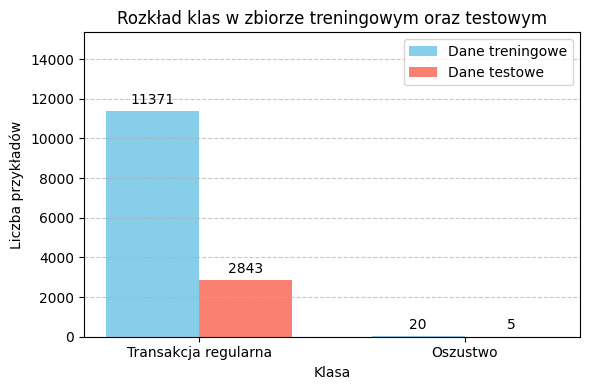

In [31]:
# Podział danych na zbiór treningowy oraz zbiór testowy
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=42)
train_test_data_split = DataSplit(train_df.drop(columns=["Class"]), test_df.drop(columns=["Class"]),
                                  train_df["Class"], test_df["Class"])
plot_class_distribution(train_test_data_split, "Rozkład klas w zbiorze treningowym oraz testowym")

# Przygotowanie podziałów danych na różne przypadki z uwględnieniem metod samplingu oraz k - krotnej walidacji
standard_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                     sampling_method=SamplingMethod.NONE)
undersampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=0.5)
undersampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=1.0)
oversampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=0.5)
oversampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=1.0)

# Do weryfikacji tylko
#plot_class_distribution(standard_data_splits, "Rozkład klas bez samplingu")
#plot_class_distribution(undersampling_50_data_splits, "Rozkład klas po undersamplingu (50%)")
#plot_class_distribution(undersampling_data_splits, "Rozkład klas po undersamplingu")
#plot_class_distribution(oversampling_50_data_splits, "Rozkład klas po oversamplingu (50%)")
#plot_class_distribution(oversampling_data_splits, "Rozkład klas po oversamplingu")

# Miary jakości

1. average_precision jest odpowiednikiem do wyznaczenia pola pod krzywą PR.
2. Nie stosuje się w praktyce klasycznego podejścia z wykorzystaniem wzoru trapezów do wyznaczenia wartości tego pola, ponieważ wg różnych badań które są wspomniane tutaj (https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) wyniki wychodziły zbyt optymistyczne niż w praktyce było.
3. Dlatego stosujemy average_precision które uśrednia wartość Precision w każdych kolejnych krokach Recall.
4. Lecz metoda poniżej na razie wyznacza też wartość tego pola w sposób klasyczny - po to żeby sobie porównać

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    auc
)

def evaluate_model(model, x_test, y_test, plot_title="Krzywa Precision-Recall", pos_label=Transaction.FRAUD.value,
                   draw_plot=True):
    """
    Ocena jakości modelu: precision, recall, F1 score, krzywa PR, average precision i interpolowana wartość AUC PR.
    Wyświetla tabelę z wynikami i wykres krzywej PR.

    Parametry:
    - model: wytrenowany model
    - x_test, y_test: dane testowe
    - plot_title: tytuł wykresu krzywej PR (domyślnie "Krzywa Precision-Recall")

    Zwraca:
    - DataFrame z metrykami modelu
    """

    # Predykcja
    y_pred = model.predict(x_test)
    if hasattr(model, "predict_proba"):
        fraud_idx = list(model.classes_).index(pos_label)
        y_scores = model.predict_proba(x_test)[:, fraud_idx]
    else:
        y_scores = model.decision_function(x_test)

    # Podstawowe metryki
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)

    # Wyznaczenie krzywej PR i metryk z nią związanych
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores, pos_label=pos_label)
    avg_precision = average_precision_score(y_test, y_scores, pos_label=pos_label)
    interpolated_auc = auc(recall_vals, precision_vals)

    # Tabelka metryk
    results_df = pd.DataFrame({
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1],
        "Avg. Precision": [avg_precision],
        "AUC PR (interpolowane)": [interpolated_auc]
    })

    print("\n Ocena jakości modelu:")
    print(results_df)
    # display(results_df)

    if draw_plot:
        # Wykres krzywej PR
        plt.figure(figsize=(6, 5))
        plt.plot(recall_vals, precision_vals, label=f"AP={avg_precision:.4f}", color='teal')
        plt.fill_between(recall_vals, precision_vals, alpha=0.1, color='teal')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(plot_title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return precision, recall, f1, avg_precision, interpolated_auc


# Badania wybranych metod do detekcji anomalii

Tutaj robię uspojnienie tego modelu badawczego

In [33]:
from datetime import datetime

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def params_tune(seed = 42):
    parameters_to_test = {
        "n_estimators": [50, 100, 200, 300],
        "max_features": ["sqrt", "log2", 0.3, 0.5, None],
        "class_weight": ["balanced", "balanced_subsample", None],  # class_weight testujemy tylko przy braku samplingu!
    }

    test_cases = [(SamplingMethod.NONE, 0, standard_data_splits),
                  (SamplingMethod.UNDER, 0.5, undersampling_50_data_splits),
                  (SamplingMethod.UNDER, 1.0, undersampling_data_splits),
                  (SamplingMethod.OVER, 0.5, oversampling_50_data_splits),
                  (SamplingMethod.OVER, 1.0, oversampling_data_splits)]

    all_results = []

    for param_name, param_values in parameters_to_test.items():
        for sampling_method, sampling_strategy, cv_splits in test_cases:
            for param_value in param_values:
                is_class_weight_test = param_name == "class_weight"
                is_data_sampled = sampling_method != SamplingMethod.NONE
                if is_class_weight_test and is_data_sampled:
                    print(f"Pomiń, ponieważ sampling method: {sampling_method} i param_name: {param_name} ")
                    # Jezeli dane sa samplowane, nie testujemy zadnych wartosci parametru "class_weight"
                    continue

                precision_list, recall_list, f1_list, avg_precision_list = [], [], [], []
                for fold_id, split in enumerate(cv_splits, 1):
                    params = {
                        "random_state": seed,
                        "n_jobs": -1,
                        param_name: param_value,
                    }
                    model = RandomForestClassifier(**params)
                    print(
                        f"({datetime.now().strftime('%H:%M:%S')}) Fold {fold_id}. {param_name}={param_value}. Sampling method {sampling_method}, sampling strategy {sampling_strategy}, ")
                    model.fit(split.x_train, split.y_train)

                    metrics_df = evaluate_model(
                        model,
                        split.x_test,
                        split.y_test,
                        pos_label=1,
                        draw_plot=False,
                    )
                    precision_list.append(metrics_df[0])
                    recall_list.append(metrics_df[1])
                    f1_list.append(metrics_df[2])
                    avg_precision_list.append(metrics_df[3])

                # Uśrednianie
                all_results.append(
                    dict(
                        sampling=sampling_method,
                        sampling_strategy=sampling_strategy,
                        param=param_name,
                        value=param_value,
                        mean_precision=np.mean(precision_list),
                        mean_recall=np.mean(recall_list),
                        mean_f1=np.mean(f1_list),
                        mean_avg_precision=np.mean(avg_precision_list),
                        # TODO: Opisac dlaczego ddof=1
                        std_avg_precision=np.std(avg_precision_list, ddof=1),
                    )
                )

    results_df = pd.DataFrame(all_results)
    results_df.to_csv("results.csv", sep='\t')

    return results_df

def train_full(train_df: pd.DataFrame, test_df: pd.DataFrame, best_params, sampling_method: SamplingMethod,
               sampling_strategy: float = 1.0, seed = 42):
    x_train = train_df.drop(columns=["Class"])
    y_train = train_df["Class"]

    x_test = test_df.drop(columns=["Class"])
    y_test = test_df["Class"]

    sampler = get_sampler(sampling_method, sampling_strategy, seed)
    if sampler:
        x_train, y_train = sampler.fit_resample(x_train, y_train)

    best_params = {
        "random_state": seed,
        "n_jobs": -1,
        "n_estimators": 100,
        "max_features": "sqrt",
        "class_weight": None,
    }
    model = RandomForestClassifier(**best_params)

    model.fit(x_train, y_train)

    metrics_df = evaluate_model(
        model,
        x_test,
        y_test,
        pos_label=1,
        draw_plot=True,
    )

    metrics_df.to_csv("results-full.csv", sep='\t')

    print(metrics_df)


def get_cmap_iterator(n, color_name):
    cmap = plt.cm.get_cmap(color_name, n)
    list = [matplotlib.colors.to_hex(cmap(i)) for i in range(n)]
    return iter(reversed(list))


def draw_plots(results: pd.DataFrame):
    results.replace({np.nan: None}, inplace=True)

    print(results)

    draw_recall_precision_plot(results)
    draw_best_f1_plot(results)
    draw_n_estimators_plot(results)


def draw_n_estimators_plot(results: pd.DataFrame):
    overs = results[(results["sampling"] == "SamplingMethod.OVER") & (results["param"] == "n_estimators")]

    plt.figure()

    for val, group in overs.groupby("sampling_strategy"):
        plt.plot(group["value"], group["mean_f1"], label=f"Sampling strategy = {val}", marker="o")

    plt.xlabel("n_estimators - liczba drzew")
    plt.ylabel("F1 - średnia z 5 walidacji krzyżowych\n")
    plt.title("F1 vs. n_estimators dla SMOTE oversampling")
    plt.tight_layout()
    plt.legend()
    plt.show()


def draw_recall_precision_plot(results: pd.DataFrame):
    filtered_results = results[(results["value"] == "100") | (results["param"] == "class_weight")]

    cmaps = [get_cmap_iterator(4, 'Purples'),
             get_cmap_iterator(5, 'Oranges'), get_cmap_iterator(4, 'Greens')]

    for sampling_method, group_sm in filtered_results.groupby("sampling"):
        sampling_strategy = SamplingMethod.from_string(sampling_method)
        if sampling_strategy == SamplingMethod.NONE:
            for value, group_val in group_sm[group_sm["param"] == "class_weight"].groupby("value", dropna=False):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_val["mean_recall"], group_val["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (class_weight={value})", color=color, alpha=0.9)
        else:
            for strategy, group_strat in group_sm.groupby("sampling_strategy"):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_strat["mean_recall"], group_strat["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (strategy={strategy})", color=color)

    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.xlabel("Średni odzysk")
    plt.ylabel("Średnia precyzja")
    plt.title("Porównanie precyzji i odzysku na podstawie metody próbkowania\n(pozostałe parametry domyślne)")
    plt.grid(True)
    plt.legend(loc="lower left", prop={'size': 8})
    plt.rcParams["figure.figsize"] = (30, 30)
    plt.show()


def draw_best_f1_plot(results: pd.DataFrame):
    names = []
    values = []
    best_f1_ids = results.groupby("sampling")["mean_f1"].idxmax()
    for id in best_f1_ids:
        entry = results.iloc[id]
        names.append(
            f"{SamplingMethod.from_string(entry['sampling']).to_string()}\nsampling_strategy: {entry['sampling_strategy']}")
        values.append(entry["mean_f1"])

        # Put this entry into plot

    plt.bar(names, values)
    plt.title('Najwyższy współczynnik F1 uzyskany dla poszczególnych strategii próbkowania')
    plt.xlabel("Strategia")
    plt.ylabel('F1 - średnia z 5 walidacji krzyżowych')
    plt.grid(True)
    plt.show()


def prepare_plots(df: pd.DataFrame):
    for param in df["param"].unique():
        plot_param(df, param)


def plot_param(results, param_name):
    subset = results[results["param"] == param_name].copy()
    sampling_methods = subset["sampling"].unique()

    # Map values to strings for categorical x-axis if needed
    subset["value_str"] = subset["value"].astype(str)

    # Build plot
    plt.figure(figsize=(6, 4))
    for sm in sampling_methods:
        sm_data = subset[subset["sampling"] == sm]
        x = sm_data["value_str"]
        y = sm_data["mean_avg_precision"]
        yerr = sm_data["std_avg_precision"]
        plt.errorbar(x, y, yerr=yerr, marker="o", label=sm, capsize=5)

    plt.title(f"{param_name} vs Average Precision")
    plt.xlabel(param_name)
    plt.ylabel("Mean AP")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Sampling")
    plt.tight_layout()
    plt.show()


## Metody nadzorowane

Trzeba opracować model, jak chcemy badać te kolejne modele i no żeby dla każdego to było spójne:

> Add blockquote



1. Zawsze odpalamy krzyżową walidację? Żeby już było mniej tych przypadków testowych, że jeszcze porównujemy
2. Przypadek undersampling vs oversampling vs bez samplingu
3. Badanie poszczególnych parametrów, które mamy wypisane w tabelce.
4. Trochę nie wiem jak podejść do tej krzyżowej walidacji i strojenia parametrów, bo pewnie ostatecznie chcemy dostać najlepszy model z najlepszym zestawem parametrów.


TODO: Opisać


### SVM z wagami klas

### Las losowy

TODO: zaladuj dane


Opis wyników:

Bez samplingu i default class weight - bardzo wysoka precyzja ale mały odzysk - duzo oszustw przejdzie nie odkrytych

undersampling - najwyzszy odzysk - ale slaba precyzja (~20%) - bedzie duzo falszywych alertow

oversampling - wysoki odzysk, wysoka precyzja - najlepszy wspolczynnik F1

bez samplingu, wykorzystujac class_weight - odzysk sie poprawil

Odzysk jest wazny bo okresli jaki procent oszustw **wykrylismy**


In [ ]:
from datetime import datetime

import matplotlib
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from lib import prepare_train_test_data_splits, evaluate_model, SamplingMethod, stratified_sample


def params_tune(df: pd.DataFrame):
    seed = 42

    train_df, test_df = train_test_split(
        df, test_size=0.20, stratify=df["Class"], random_state=seed
    )

    stratified_df = stratified_sample(train_df, frac=0.2, seed=42)

    parameters_to_test = {
        "n_estimators": [50, 100, 200, 300],
        "max_features": ["sqrt", "log2", 0.3, 0.5, None],
        "class_weight": ["balanced", "balanced_subsample", None],  # class_weight testujemy tylko przy braku samplingu!
    }

    samplings_to_test = [(SamplingMethod.NONE, None), (SamplingMethod.UNDER, 0.5), (SamplingMethod.UNDER, 1.0),
                         (SamplingMethod.OVER, 0.5), (SamplingMethod.OVER, 1.0)]

    all_results = []

    for param_name, param_values in parameters_to_test.items():
        for sampling_method, sampling_strategy in samplings_to_test:
            for param_value in param_values:
                is_class_weight_test = param_name == "class_weight"
                is_data_sampled = sampling_method != SamplingMethod.NONE
                if is_class_weight_test and is_data_sampled:
                    print(f"Pomiń, ponieważ sampling method: {sampling_method} i param_name: {param_name} ")
                    # Jezeli dane sa samplowane, nie testujemy zadnych wartosci parametru "class_weight"
                    continue

                k = 5
                cv_splits = prepare_train_test_data_splits(stratified_df, sampling_method=sampling_method,
                                                           sampling_strategy=sampling_strategy, k=k)
                precision_list, recall_list, f1_list, avg_precision_list = [], [], [], []
                for fold_id, split in enumerate(cv_splits, 1):
                    params = {
                        "random_state": seed,
                        "n_jobs": -1,
                        param_name: param_value,
                    }
                    model = RandomForestClassifier(**params)
                    print(
                        f"({datetime.now().strftime('%H:%M:%S')}) Fold {fold_id}. {param_name}={param_value}. Sampling method {sampling_method}, sampling strategy {sampling_strategy}, ")
                    model.fit(split.x_train, split.y_train)

                    metrics_df = evaluate_model(
                        model,
                        split.x_test,
                        split.y_test,
                        pos_label=1,
                        draw_plot=False,
                    )
                    precision_list.append(metrics_df[0])
                    recall_list.append(metrics_df[1])
                    f1_list.append(metrics_df[2])
                    avg_precision_list.append(metrics_df[3])

                # po 5 foldach – uśredniamy
                all_results.append(
                    dict(
                        sampling=sampling_method,
                        sampling_strategy=sampling_strategy,
                        param=param_name,
                        value=param_value,
                        mean_precision=np.mean(precision_list),
                        mean_recall=np.mean(recall_list),
                        mean_f1=np.mean(f1_list),
                        mean_avg_precision=np.mean(avg_precision_list),
                        # TODO: Opisac dlaczego ddof=1
                        std_avg_precision=np.std(avg_precision_list, ddof=1),
                    )
                )

    results_df = pd.DataFrame(all_results)
    results_df.to_csv("results.csv", sep='\t')

    return results_df


def train_full(df: pd.DataFrame, best_params, sampling: SamplingMethod):
    seed = 42

    train_df, test_df = train_test_split(
        df, test_size=0.20, stratify=df["Class"], random_state=seed
    )

    x = train_df.drop(columns=["Class"])
    y = train_df["Class"]

    x_test = test_df.drop(columns=["Class"])
    y_test = test_df["Class"]

    x_train, y_train = SMOTE().fit_resample(x, y)

    best_params = {
        "random_state": seed,
        "n_jobs": -1,
        "n_estimators": 100,
        "max_features": "sqrt",
        "class_weight": None,
    }
    model = RandomForestClassifier(**best_params)

    model.fit(x_train, y_train)

    metrics_df = evaluate_model(
        model,
        x_test,
        y_test,
        pos_label=1,
        draw_plot=True,
    )

    metrics_df.to_csv("results-full.csv", sep='\t')

    print(metrics_df)


def get_cmap_iterator(n, color_name):
    cmap = plt.cm.get_cmap(color_name, n)
    list = [matplotlib.colors.to_hex(cmap(i)) for i in range(n)]
    return iter(reversed(list))


def draw_plots(results: pd.DataFrame):
    results.replace({np.nan: None}, inplace=True)

    print(results)

    draw_recall_precision_plot(results)
    draw_best_f1_plot(results)
    draw_n_estimators_plot(results)


def draw_n_estimators_plot(results: pd.DataFrame):
    overs = results[(results["sampling"] == "SamplingMethod.OVER") & (results["param"] == "n_estimators")]

    plt.figure()

    for val, group in overs.groupby("sampling_strategy"):
        plt.plot(group["value"], group["mean_f1"], label=f"Sampling strategy = {val}", marker="o")

    plt.xlabel("n_estimators - liczba drzew")
    plt.ylabel("F1 - średnia z 5 walidacji krzyżowych\n")
    plt.title("F1 vs. n_estimators dla SMOTE oversampling")
    plt.tight_layout()
    plt.legend()
    plt.show()


def draw_recall_precision_plot(results: pd.DataFrame):
    filtered_results = results[(results["value"] == "100") | (results["param"] == "class_weight")]

    cmaps = [get_cmap_iterator(4, 'Purples'),
             get_cmap_iterator(5, 'Oranges'), get_cmap_iterator(4, 'Greens')]

    for sampling_method, group_sm in filtered_results.groupby("sampling"):
        sampling_strategy = SamplingMethod.from_string(sampling_method)
        if sampling_strategy == SamplingMethod.NONE:
            for value, group_val in group_sm[group_sm["param"] == "class_weight"].groupby("value", dropna=False):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_val["mean_recall"], group_val["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (class_weight={value})", color=color, alpha=0.9)
        else:
            for strategy, group_strat in group_sm.groupby("sampling_strategy"):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_strat["mean_recall"], group_strat["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (strategy={strategy})", color=color)

    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.xlabel("Średni odzysk")
    plt.ylabel("Średnia precyzja")
    plt.title("Porównanie precyzji i odzysku na podstawie metody próbkowania\n(pozostałe parametry domyślne)")
    plt.grid(True)
    plt.legend(loc="lower left", prop={'size': 8})
    plt.rcParams["figure.figsize"] = (30, 30)
    plt.show()


def draw_best_f1_plot(results: pd.DataFrame):
    names = []
    values = []
    best_f1_ids = results.groupby("sampling")["mean_f1"].idxmax()
    for id in best_f1_ids:
        entry = results.iloc[id]
        names.append(
            f"{SamplingMethod.from_string(entry['sampling']).to_string()}\nsampling_strategy: {entry['sampling_strategy']}")
        values.append(entry["mean_f1"])

        # Put this entry into plot

    plt.bar(names, values)
    plt.title('Najwyższy współczynnik F1 uzyskany dla poszczególnych strategii próbkowania')
    plt.xlabel("Strategia")
    plt.ylabel('F1 - średnia z 5 walidacji krzyżowych')
    plt.grid(True)
    plt.show()


def prepare_plots(df: pd.DataFrame):
    for param in df["param"].unique():
        plot_param(df, param)


def plot_param(results, param_name):
    subset = results[results["param"] == param_name].copy()
    sampling_methods = subset["sampling"].unique()

    # Map values to strings for categorical x-axis if needed
    subset["value_str"] = subset["value"].astype(str)

    # Build plot
    plt.figure(figsize=(6, 4))
    for sm in sampling_methods:
        sm_data = subset[subset["sampling"] == sm]
        x = sm_data["value_str"]
        y = sm_data["mean_avg_precision"]
        yerr = sm_data["std_avg_precision"]
        plt.errorbar(x, y, yerr=yerr, marker="o", label=sm, capsize=5)

    plt.title(f"{param_name} vs Average Precision")
    plt.xlabel(param_name)
    plt.ylabel("Mean AP")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Sampling")
    plt.tight_layout()
    plt.show()


Wyniki:

TODO: Wydrukuj wyniki

TODO: Wykresy maja byc wygenerowane w python

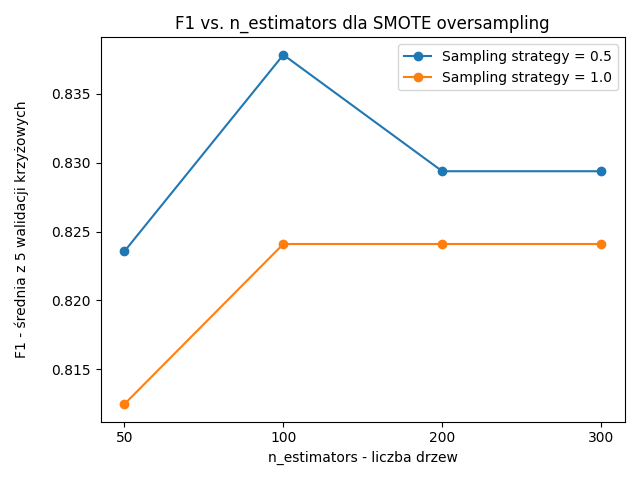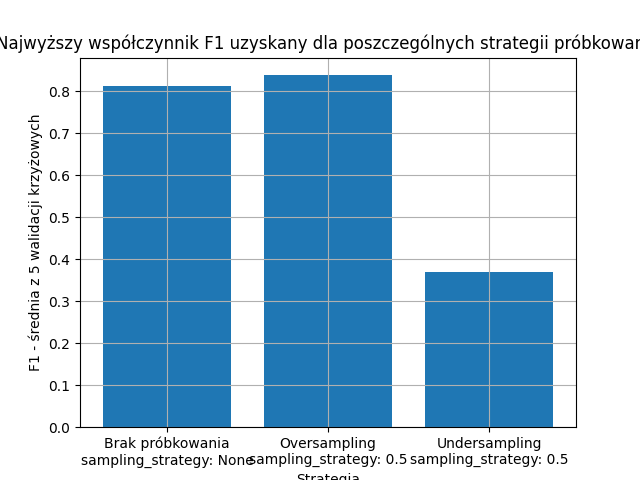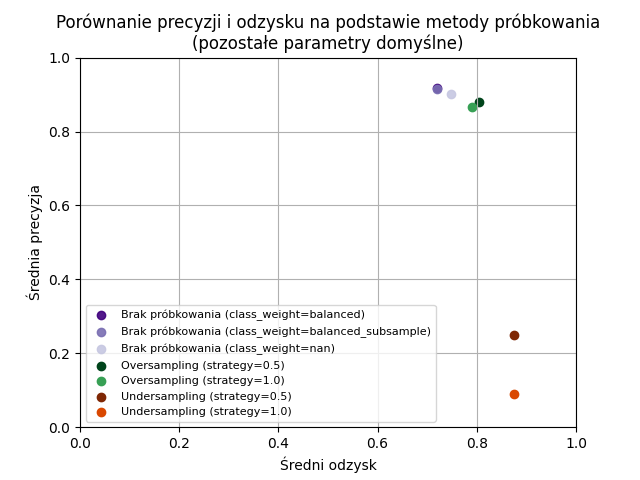

Ostateczne pamaetry modelu dla najlepszych parametrów - do testów uzyto 20% zbioru ktory nie był używany w trakcie procesu

   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.961538  0.852273  0.903614        0.891871                0.897822






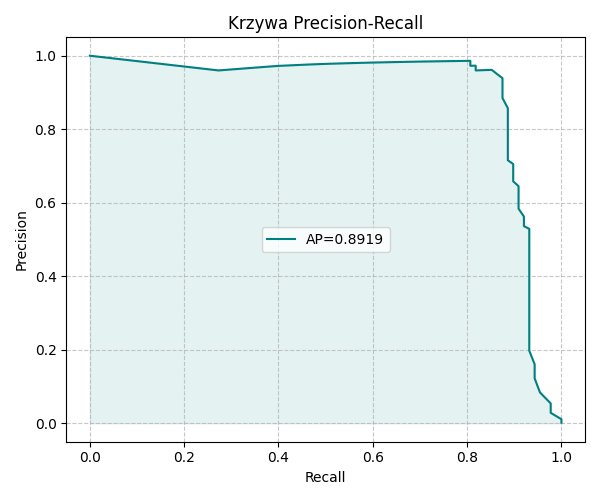

### Drzewo decyzyjne z wagami klas







### XG Boost

## Metody nienadzorowane

### One-Class SVM

Tutaj na razie wstępny wywołanie, żeby zobaczyć czy mniej więcej działa metoda do oceny jakości modelu.

In [14]:
from sklearn.svm import OneClassSVM

# Parametry do badania
kernel = ['linear', 'rbf']
nu = [0.01, 0.05, 0.1, 0.2]
# Tylko dla kernel='rbf'
gamma = ['scale', 'auto', 0.01, 0.1, 1.0]

def train_ocsvm(data_splits, kernel='rbf', nu=0.05, gamma='scale'):
    models = []
    for data_split in data_splits:
        model = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
        model.fit(data_split.x_train)
        models.append(model)
    return models

models = train_ocsvm(training_test_data_split)

In [ ]:
for i, model in enumerate(models, 1):
    print(f"Model {i}:")
    evaluate_model(model, training_test_data_split[0].x_test, training_test_data_split[0].y_test,
                   plot_title=f"Krzywa PR dla modelu {i} (One-Class SVM)")

### Las izolacyjny

In [ ]:
# Parametry do badania
n_estimators = [50, 100, 200, 300]
max_samples = ['auto', 128, 256, 512]
contamination = [0.0001, 0.001, 0.005, 0.01]

### Lokalny czynnik odstający

In [ ]:
# Parametry do badania
n_neighbors = [5, 10, 20, 35, 50]
contamination = [0.0001, 0.001, 0.005, 0.01]

### DBSCAN


In [ ]:
# Parametry do badania
eps = [0.5, 1.0, 1.5, 2.0, 3.0]
min_samples = [10, 20, 50, 100]